In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline

In [2]:
# FROM MTL NOTEBOOK - ONLY USED FOR REFERENCE

def plot_summary(history, save_to=None):
    for key, value in history.items():
      history[key] = np.array(value)
    
    print(history['ekman_loss/train'].shape)
    x = np.arange(history['ekman_loss/train'].shape[1]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)

    plt.figure(figsize=(20, 10))

    plots = [{
          'title': 'Weights',
          'lines': {
              'Ekman': history['weights/ekman'],
              'Vad': history['weights/vad'],
              'Sem': history['weights/sem']
            }
        }
    ]

    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    for (i, plot) in enumerate(plots):
        plt.subplot(2, 3, i+1)
        plt.title(plot['title'])
        for j, (label, lines) in enumerate(plot['lines'].items()):
          mean =  lines.mean(axis=0).squeeze()
          std = lines.std(axis=0).squeeze()

          mean = make_interp_spline(x, mean)(x_dense)
          std = make_interp_spline(x, std)(x_dense)
          plt.plot(x_dense, mean, color=colors[j], label=label)
          plt.fill_between(x_dense, mean+std, mean-std, color=colors[j], alpha=0.3)

          if plot['title'] == 'VAD Loss':
            plt.ylim(0.3, 0.5)
        plt.legend()
    plt.show()

In [4]:
def load_history(path):
    # load in the weights history for ekman, vad, and sem
    ekman = pd.read_csv('w_ekman.csv')
    vad = pd.read_csv('w_vad.csv')
    sem = pd.read_csv('w_sem.csv')

    # extract only the relevant columns
    ekman_cols = [col for col in ekman.columns if 'weights/ekman' in col and 'MIN' not in col and 'MAX' not in col]
    vad_cols = [col for col in vad.columns if 'weights/vad' in col and 'MIN' not in col and 'MAX' not in col]
    sem_cols = [col for col in sem.columns if 'weights/sem' in col and 'MIN' not in col and 'MAX' not in col]

    # only keep step and weights columns, up to the 100th step/row
    ekman = ekman[['Step'] + ekman_cols][:100]
    vad = vad[['Step'] + vad_cols][:100]
    sem = sem[['Step'] + sem_cols][:100]

    # convert to numpy arrays
    ekman = ekman.to_numpy()
    vad = vad.to_numpy()
    sem = sem.to_numpy()

    # average the weights across the 10 runs
    ekman_mean = ekman[:, 1:].mean(axis=1)
    vad_mean = vad[:, 1:].mean(axis=1)
    sem_mean = sem[:, 1:].mean(axis=1)

    ekman_std = ekman[:, 1:].std(axis=1)
    vad_std = vad[:, 1:].std(axis=1)
    sem_std = sem[:, 1:].std(axis=1)

    # concatenate the average and std weights 
    ekman = np.concatenate((np.expand_dims(ekman_mean, axis=-1), np.expand_dims(ekman_std,axis=-1)),axis=1)
    vad = np.concatenate((np.expand_dims(vad_mean, axis=-1), np.expand_dims(vad_std,axis=-1)),axis=1)
    sem = np.concatenate((np.expand_dims(sem_mean, axis=-1), np.expand_dims(sem_std,axis=-1)),axis=1)

    return ekman, vad, sem

In [38]:
# plot the averaged weights on the same graph as a function of steps
def plot_weights(values, labels, save_to=None):
    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    x = np.arange(values[0].shape[0]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)
    for i, vals in enumerate(values):
        mean = vals[:,0].squeeze()
        std = vals[:,1].squeeze()

        mean = make_interp_spline(x, mean)(x_dense)
        std = make_interp_spline(x, std)(x_dense)
        plt.plot(x_dense, mean, color=colors[i], label=labels[i])
        plt.fill_between(x_dense, mean+std, mean-std, color=colors[i], alpha=0.3)
        plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Weight')
    plt.frameon = False
    plt.show()

    if save_to is not None:
        plt.savefig(save_to, dpi=300)

def plot_weights(values, labels, save_to=None):
    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    x = np.arange(values[0].shape[0]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for i, vals in enumerate(values):
        mean = vals[:,0].squeeze()
        std = vals[:,1].squeeze()

        mean = make_interp_spline(x, mean)(x_dense)
        std = make_interp_spline(x, std)(x_dense)
        ax.plot(x_dense, mean, color=colors[i], label=labels[i])
        ax.fill_between(x_dense, mean+std, mean-std, color=colors[i], alpha=0.3)
        plt.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Weight')
    plt.show()

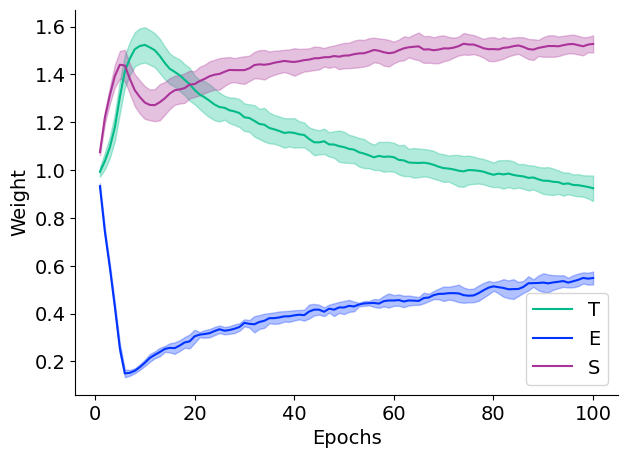

In [42]:
labels = ['T', 'E', 'S']
name = 'weights'
path = f'./{name}'
ekman, vad, sem = load_history(path)
plt.rcParams.update({'font.size': 14})
plot_weights([ekman, vad, sem], labels, save_to=path)